Библиотеки

In [1]:
from __future__ import annotations
from typing import NamedTuple, TypedDict, Callable
import torch
from olimp.processing import fft_conv
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from olimp.processing import fft_conv
from olimp.precompensation.nn.dataset.psf_gauss import PsfGaussDataset
from ballfish.distribution import DistributionParams
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity as ssim


Основные функции для работы с файлами

In [2]:
def plot_and_save_results(original, psf, blurred_noisy, restored, noise_std, psnr_blurred, ssim_blurred, 
                         psnr_restored, ssim_restored, output_path):
    """Визуализация и сохранение результатов"""
    # Преобразуем тензоры в numpy массивы
    if torch.is_tensor(original):
        original = original.squeeze().cpu().detach().numpy()
    if torch.is_tensor(psf):
        psf = psf.squeeze().cpu().detach().numpy()
    if torch.is_tensor(blurred_noisy):
        blurred_noisy = blurred_noisy.squeeze().cpu().detach().numpy()
    if torch.is_tensor(restored):
        restored = restored.squeeze().cpu().detach().numpy()

    plt.figure(figsize=(20, 10))
    
    # Первый ряд
    plt.subplot(141)
    plt.imshow(original, cmap='gray', vmin=0, vmax=1)
    plt.title('Исходное изображение')
    plt.axis('off')
    
    plt.subplot(142)
    plt.imshow(psf, cmap='gray')
    plt.title('ФРТ')
    plt.axis('off')
    
    plt.subplot(143)
    plt.imshow(blurred_noisy, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Размытое + шум (σ={noise_std})\nPSNR={psnr_blurred:.2f}\nSSIM={ssim_blurred:.4f}')
    plt.axis('off')
    
    plt.subplot(144)
    plt.imshow(restored, cmap='gray', vmin=0, vmax=1)
    plt.title(f'Восстановленное\nPSNR={psnr_restored:.2f}\nSSIM={ssim_restored:.4f}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()

Считаем метрики

In [3]:
def psnr(img_true, img_test, data_range=1.0):
 
    if img_true.shape != img_test.shape:
        raise ValueError("Изображения должны иметь одинаковый размер.")
    if data_range is None:
        data_range = np.max(img_true) - np.min(img_true)
        if data_range == 0:  
            data_range = 1.0  
    psnr_value = peak_signal_noise_ratio(
        img_true,
        img_test,
        data_range=data_range
    )

    return psnr_value
"""
def psnr(original, compared, data_range=1.0):
 
    mse = np.mean((original - compared) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(data_range) - 10 * np.log10(mse)

"""
def calculate_metrics(original, compared):
    """Расчет PSNR и SSIM"""
    if torch.is_tensor(original):
        original = original.cpu().numpy()
    if torch.is_tensor(compared):
        compared = compared.cpu().detach().numpy()
    if original.ndim > 2:
        original = original.squeeze()
    if compared.ndim > 2:
        compared = compared.squeeze()
    
    original = np.clip(original, 0, 1)
    compared = np.clip(compared, 0, 1)
    
    return psnr(original, compared, data_range=1.0), ssim(original, compared, data_range=1.0)

In [4]:

                                                        
def work_with_image(
    results_dir: str,
    output_dir: str,
    deconv_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
    method_name: str,
):
    os.makedirs(results_dir, exist_ok=True)
    metrics_file = os.path.join(results_dir, "metrics.txt")
    with open(metrics_file, "w") as f:
            f.write("Файл\tШум\tPSNR(размытое)\tSSIM(размытое)\tPSNR(восст.)\tSSIM(восст.)\tdelta_ssim\tdelta_psnr\n")


    # Обработка всех файлов
    for file in os.listdir(output_dir):
            if file.endswith(".pt"):
                print(f"\nОбработка {file}")
                try:
                    data_dict = torch.load(os.path.join(output_dir, file))
                    
                    original = data_dict['original']
                    psf = data_dict['psf']
                    blurred_noisy = data_dict['blurred_noisy']
                    noise_std = data_dict['noise_std']
                    
                   # print(f"Размерности тензоров:")
                    #print(f"Оригинал: {original.shape}")
                    #print(f"ФРТ: {psf.shape}")
                    #print(f"Размытое: {blurred_noisy.shape}")
                    
                    restored = deconv_function(blurred_noisy, psf)
                    
                    psnr_blurred, ssim_blurred = calculate_metrics(original, blurred_noisy)
                    psnr_restored, ssim_restored = calculate_metrics(original, restored)
                    delta_psnr = psnr_restored - psnr_blurred
                    delta_ssim = ssim_restored - ssim_blurred
                    
                    with open(metrics_file, "a") as f:
                        f.write(f"{file}\t{noise_std}\t{psnr_blurred:.2f}\t{ssim_blurred:.4f}\t"
                            f"{psnr_restored:.2f}\t{ssim_restored:.2f}\t{delta_ssim:.2f}\t{delta_psnr:.2f}\n")
                    
                    output_path = os.path.join(results_dir, f"restored_{file[:-3]}.png")
                    plot_and_save_results(
                        original, psf, blurred_noisy, restored,
                        noise_std, psnr_blurred, ssim_blurred,
                        psnr_restored, ssim_restored,
                        output_path
                    )
                    
                except Exception as e:
                    print(f"Ошибка при обработке файла {file}: {str(e)}")
                    import traceback
                    traceback.print_exc()
                    continue

    print("\nОбработка завершена!")
    print(f"Результаты сохранены в директории: {results_dir}")
    print(f"Метрики сохранены в файле: {metrics_file}")

Методы восстановления

Метод HQS

In [7]:

class HQSParameters(NamedTuple):
    lr: float = 1e-2
    c_high: float = 0.96
    c_low: float = 1.0 - c_high
    gap: float = 1e-6
    gap_on_iteration: float = 1e-5
    mu: float = 1e-3*0.017
    beta: float = 1e-5*0.89
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = None

def _grad_operators(shape: torch.Size) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Генерирует операторы градиента Dx и Dy на основе заданной формы.
    Эта версия правильно обрабатывает 2D тензоры (изображения).
    """
    #print(f"Форма, полученная в grad_operators: {shape}")

    if len(shape) != 2:
        raise ValueError(f"Входная форма должна быть 2D (высота, ширина), но получена форма {shape}")

    rows, cols = shape
    Dx = torch.zeros(shape)
    Dy = torch.zeros(shape)

    Dx[0, 1] = 1
    Dx[0, 0] = -1  # Горизонтальный градиент (направление x)

    Dy[1, 0] = 1
    Dy[0, 0] = -1   # Вертикальный градиент (направление y)

    return (Dx, Dy)


def _grad(image: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
    #print(f"Форма p0 перед grad_operators: {image.shape}")  # ОЧЕНЬ ВАЖНО
    Dx, Dy = _grad_operators(image.shape)
    image_dx = fft_conv(image, Dx)
    image_dy = fft_conv(image, Dy)
    return image_dx, image_dy


def _w_subproblem_solver(
    p: torch.Tensor, beta: float
) -> tuple[torch.Tensor, torch.Tensor]:
    Dx, Dy = _grad_operators(p.shape)

    du_x = fft_conv(p, Dx)
    du_y = fft_conv(p, Dy)

    wx = torch.maximum(
        torch.sum(torch.abs(du_x)) - 1 / beta, torch.zeros(p.shape)
    ) * torch.sign(du_x)
    wy = torch.maximum(
        torch.sum(torch.abs(du_y)) - 1 / beta, torch.zeros(p.shape)
    ) * torch.sign(du_y)

    return (wx, wy)


def _clip(image: torch.Tensor) -> torch.Tensor:
    return image.clip(0.0, 1.0)


def hqs(
    image: torch.Tensor,
    psf: torch.Tensor,
    parameters: HQSParameters = HQSParameters(),
) -> torch.Tensor:

    # Parameters
    lr = parameters.lr
    gap = parameters.gap
    gap_iter = parameters.gap_on_iteration

    # Constant
    beta = parameters.beta
    mu = parameters.mu

    # Preparing image
    t = image * (parameters.c_high - parameters.c_low) + parameters.c_low

    # Calculating loss
    loss_step: list[float] = []
    if parameters.debug is not None:
        parameters.debug["loss_step"] = loss_step

    progress: Callable[[float], None] = (
        lambda val: parameters.progress and parameters.progress(val)
    )
    progress(0.1)

    p0 = t

    for k in range(5000):
        # Solving w-subproblem
        #print(k)
        wx, wy = _w_subproblem_solver(p0, beta)

        # Solving p-subproblem
        p = p0.clone().detach().requires_grad_(True)
        optimizer = torch.optim.Adam([p], lr=lr)
        prev_loss_iter = torch.tensor(float("inf"))

        for i in range(1000):
            p_lim = _clip(p)
            p_dx, p_dy = _grad(p_lim)
            retinal = fft_conv(p_lim, psf)

            # Loss function
            func1 = torch.sum(torch.square(retinal - t))
            func2 = torch.sum(
                torch.square(wx - p_dx) + torch.square(wy - p_dy)
            )
            loss_func = (mu / 2) * func1 + (beta / 2) * func2

            # Optimization
            optimizer.zero_grad()
            loss_func.backward(retain_graph=True)
            optimizer.step()

            if torch.abs(prev_loss_iter - loss_func).item() < gap:
                break

            prev_loss_iter = loss_func

        if parameters.debug is not None:
            parameters.debug["p"] = _clip(p)

        criteria = torch.sum(torch.abs(p0 - _clip(p))) / (
            p0.shape[-1] * p0.shape[-2]
        )
        loss_step.append(criteria.item())
        if len(loss_step) > 1 and loss_step[-2] * 1.1 < loss_step[-1]:
            return p0
        if criteria < gap_iter:
            break

        p0 = _clip(p)
        progress(0.2 + (k / 19) * 0.8)

    progress(1.0)
    return p0


Использование
1 датасет
FRT1
class HQSParameters(NamedTuple):
    lr: float = 1e-3
    c_high: float = 0.99
    c_low: float = 1.0 - c_high
    gap: float = 1e-4
    gap_on_iteration: float = 1e-5
    mu: float = 1e-3
    beta: float = 1e-5
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = None

для data_1_frt:
class HQSParameters(NamedTuple):
    lr: float = 1e-2
    c_high: float = 0.96
    c_low: float = 1.0 - c_high
    gap: float = 1e-6
    gap_on_iteration: float = 1e-5
    mu: float = 1e-3*0.015
    beta: float = 1e-5*0.82
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = None


Обработка ruler.512_frt4_noise0.01.pt


/tmp/ipykernel_27913/1022540450.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(os.path.join(output_dir, file))


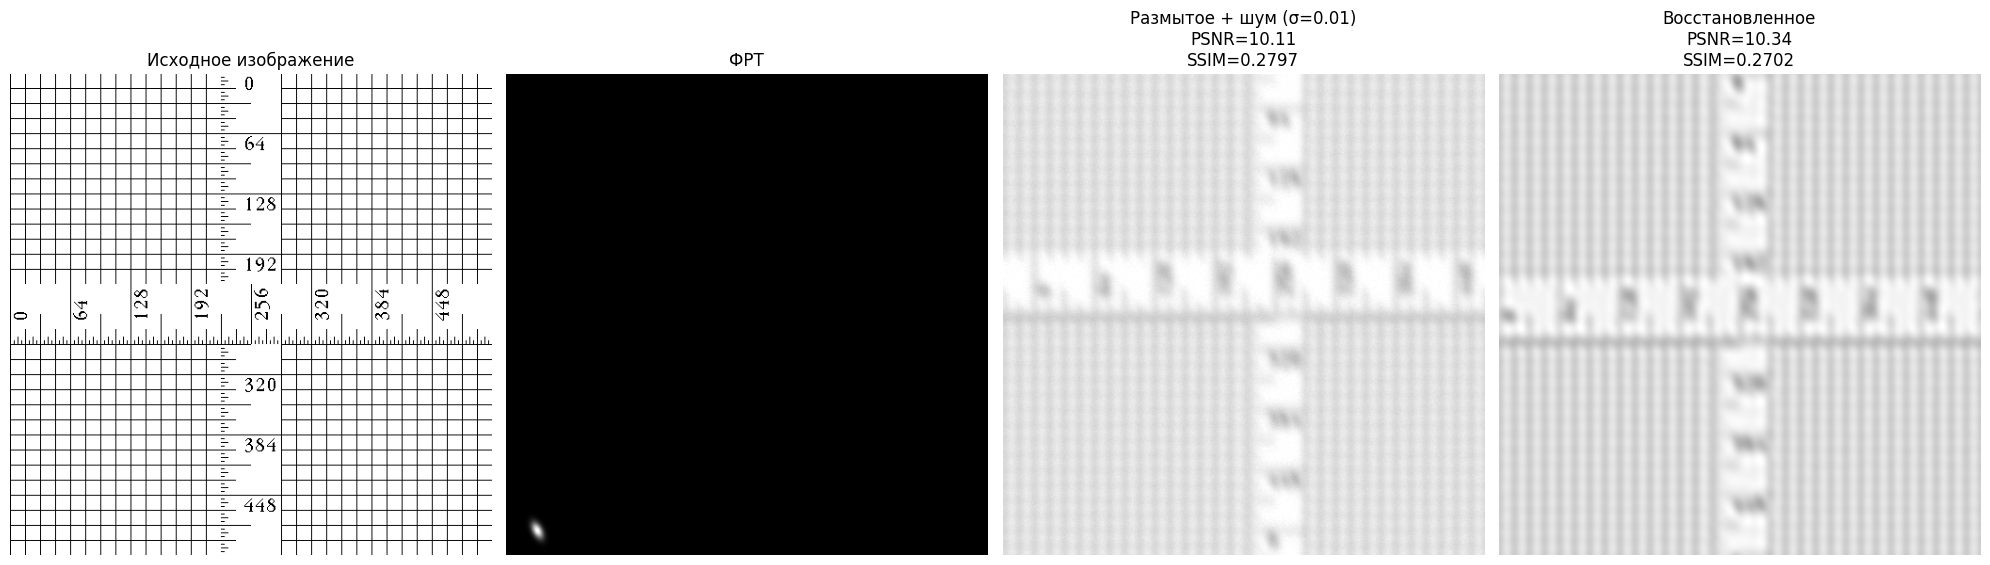


Обработка ruler.512_frt4_noise0.1.pt


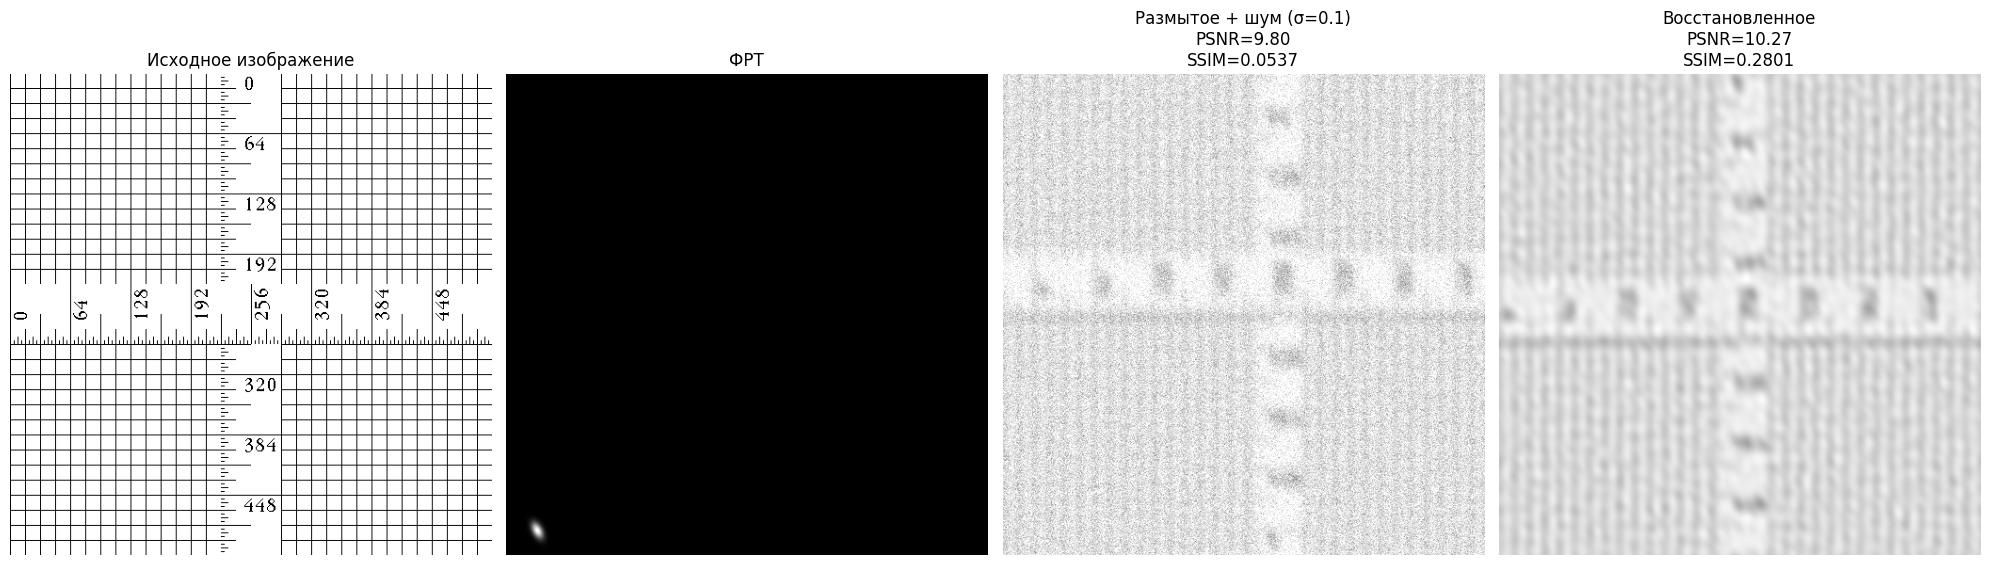


Обработка ruler.512_frt4_noise0.05.pt


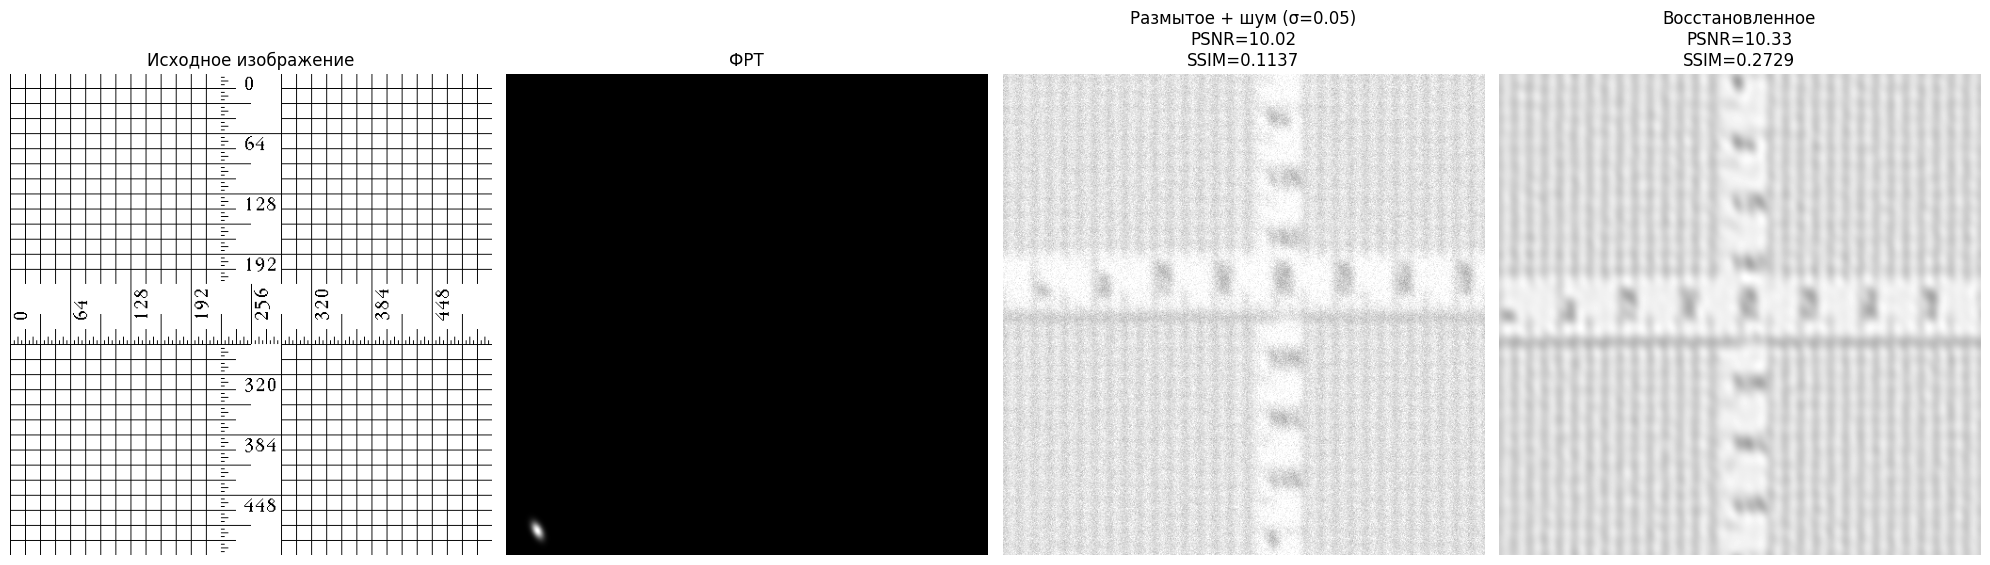


Обработка завершена!
Результаты сохранены в директории: результаты_восстановления_HQS_4set_frt4
Метрики сохранены в файле: результаты_восстановления_HQS_4set_frt4/metrics.txt


In [ ]:

output_dir = "выходные_данные_4_frt4"
results_dir = "результаты_восстановления_HQS_4set_frt4"
work_with_image(results_dir, output_dir, hqs, 'hqs')


class HQSParameters(NamedTuple):
    lr: float = 1e-4
    c_high: float = 0.98
    c_low: float = 1.0 - c_high
    gap: float = 1e-4
    gap_on_iteration: float = 1e-5
    mu: float = 1e-2
    beta: float = 1e-4
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = Noneone

1 датасет
FRT3
class HQSParameters(NamedTuple):
    lr: float = 1e-3
    c_high: float = 0.98
    c_low: float = 1.0 - c_high
    gap: float = 1e-4
    gap_on_iteration: float = 1e-5
    mu: float = 1e-3
    beta: float = 1e-5
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = None


In [ ]:

output_dir = "выходные_данные_1_frt3"
results_dir = "результаты_восстановления_HQS_1set_frt3"
work_with_image(results_dir, output_dir, hqs, 'hqs')

2 датасет

Использование
2 датасет
FRT2
class HQSParameters(NamedTuple):
    lr: float = 1e-4
    c_high: float = 0.98
    c_low: float = 1.0 - c_high
    gap: float = 1e-4
    gap_on_iteration: float = 1e-5
    mu: float = 1e-2
    beta: float = 1e-4
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = None



Обработка 5.1.12_frt2_noise0.05.pt


/tmp/ipykernel_26665/1022540450.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(os.path.join(output_dir, file))


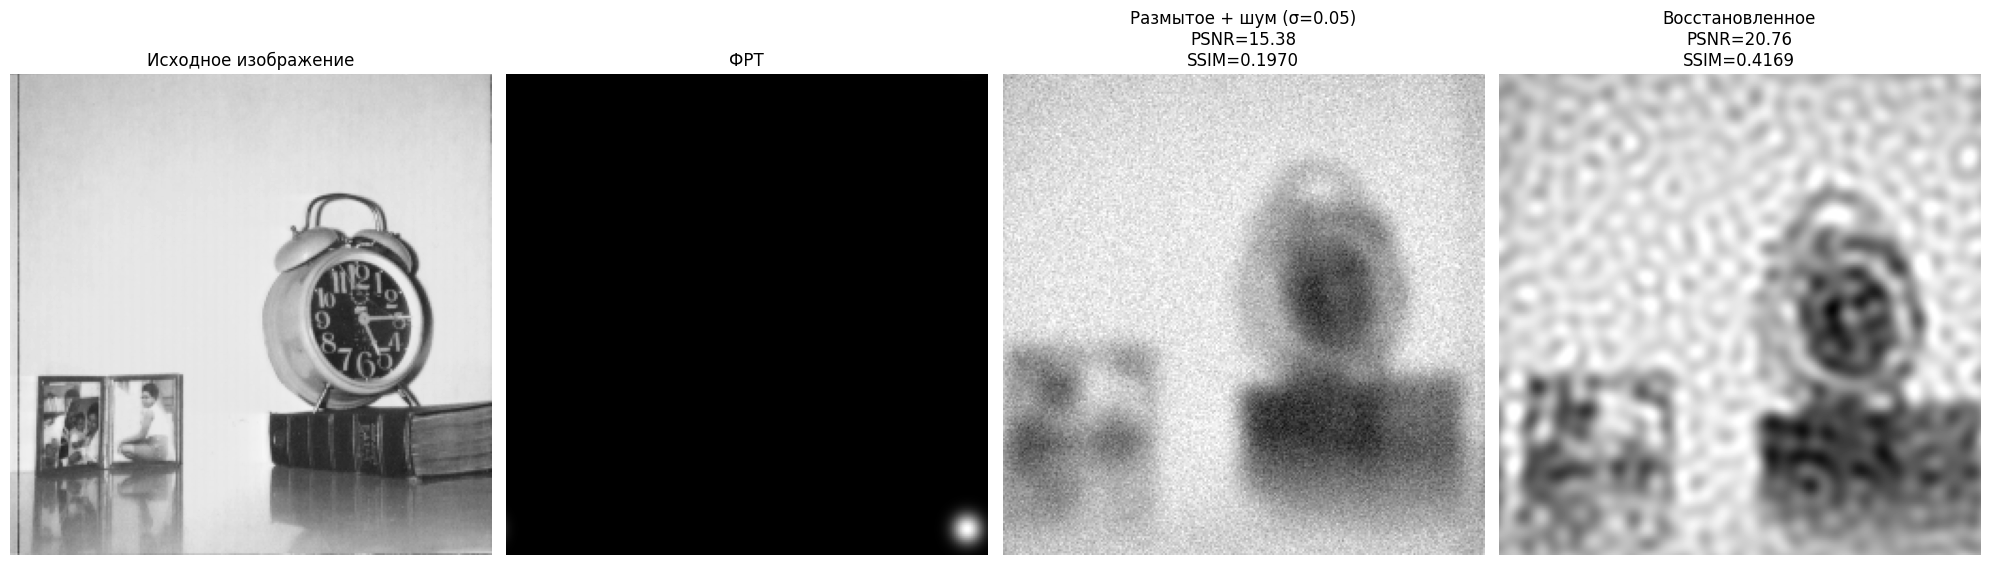


Обработка 5.1.12_frt2_noise0.01.pt


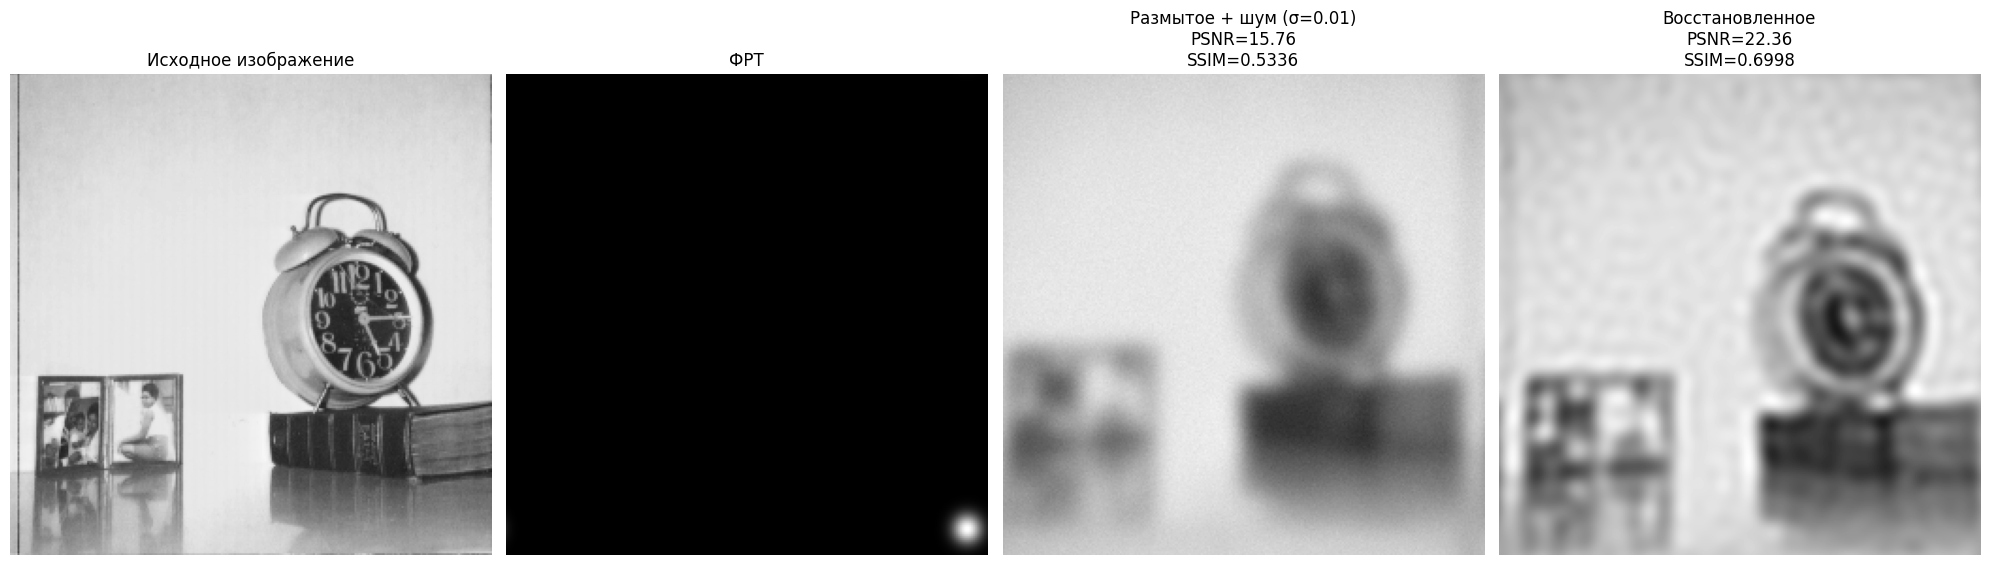


Обработка 5.1.12_frt2_noise0.1.pt


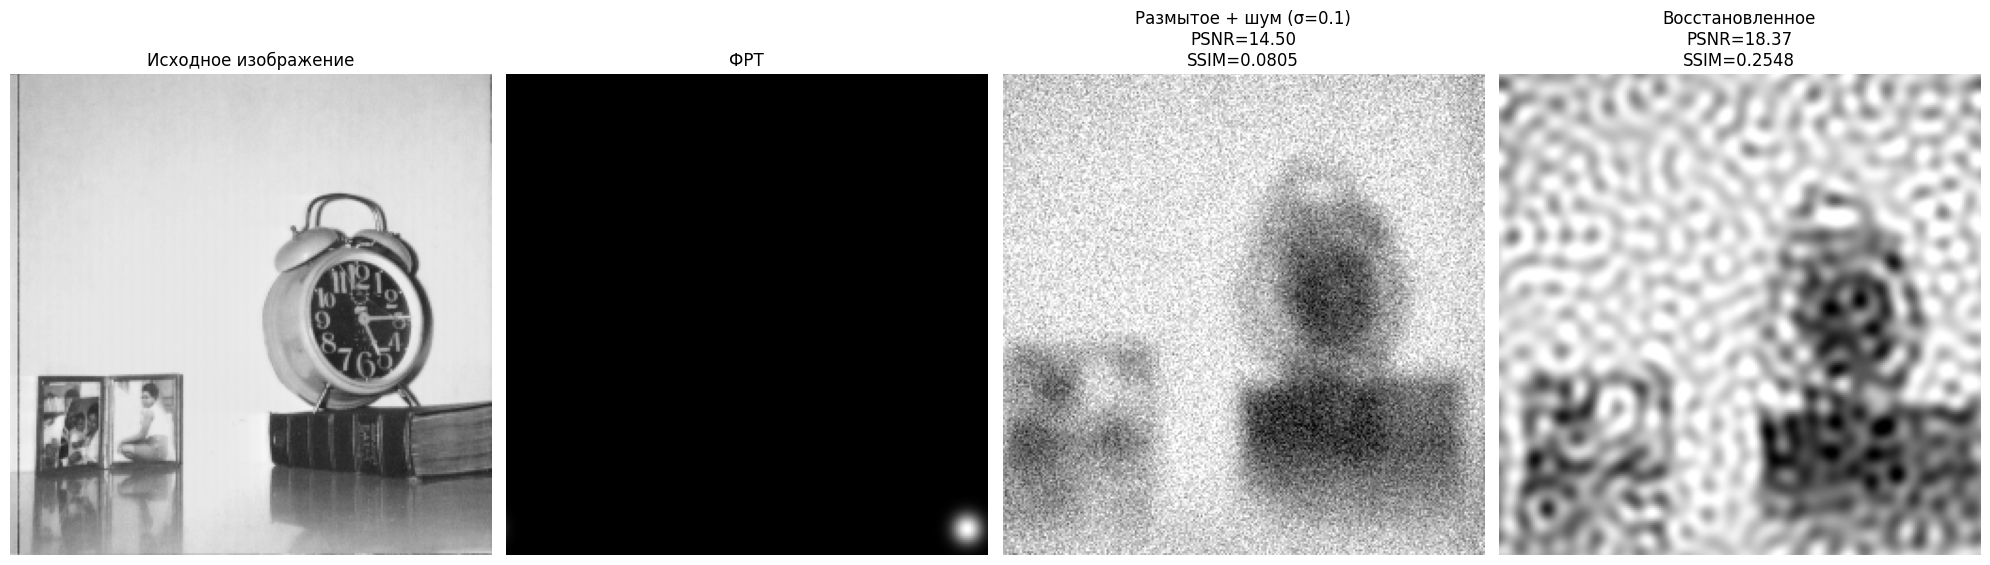


Обработка завершена!
Результаты сохранены в директории: результаты_восстановления_HQS_2set_frt2
Метрики сохранены в файле: результаты_восстановления_HQS_2set_frt2/metrics.txt


In [10]:

output_dir = "выходные_данные_2_frt2"
results_dir = "результаты_восстановления_HQS_2set_frt2"
work_with_image(results_dir, output_dir, hqs, 'hqs')



Использование
2 датасет
FRT1
class HQSParameters(NamedTuple):
    lr: float = 1e-3
    c_high: float = 0.99
    c_low: float = 1.0 - c_high
    gap: float = 1e-4
    gap_on_iteration: float = 1e-5
    mu: float = 1e-3
    beta: float = 1e-5
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = None

In [9]:
"""
output_dir = "выходные_данные_2_frt1"
results_dir = "результаты_восстановления_HQS_2set_frt1"
work_with_image(results_dir, output_dir, hqs, 'hqs')
"""

'\noutput_dir = "выходные_данные_2_frt1"\nresults_dir = "результаты_восстановления_HQS_2set_frt1"\nwork_with_image(results_dir, output_dir, hqs, \'hqs\')\n'

Использование
3 датасет
FRT1
class HQSParameters(NamedTuple):
    lr: float = 1e-3
    c_high: float = 0.99
    c_low: float = 1.0 - c_high
    gap: float = 1e-4
    gap_on_iteration: float = 1e-5
    mu: float = 1e-3
    beta: float = 1e-5
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = None

In [10]:
"""
output_dir = "выходные_данные_3_frt1"
results_dir = "результаты_восстановления_HQS_3set_frt1"
work_with_image(results_dir, output_dir, hqs, 'hqs')
"""

'\noutput_dir = "выходные_данные_3_frt1"\nresults_dir = "результаты_восстановления_HQS_3set_frt1"\nwork_with_image(results_dir, output_dir, hqs, \'hqs\')\n'

3 датасет FRT2
class HQSParameters(NamedTuple):
    lr: float = 1e-3
    c_high: float = 0.99
    c_low: float = 1.0 - c_high
    gap: float = 1e-4
    gap_on_iteration: float = 1e-5
    mu: float = 1e-3
    beta: float = 1e-5
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = None

In [11]:
"""
output_dir = "выходные_данные_3_frt2"
results_dir = "результаты_восстановления_HQS_3set_frt2"
work_with_image(results_dir, output_dir, hqs, 'hqs')
"""

'\noutput_dir = "выходные_данные_3_frt2"\nresults_dir = "результаты_восстановления_HQS_3set_frt2"\nwork_with_image(results_dir, output_dir, hqs, \'hqs\')\n'

Использование
4 датасет
FRT1
class HQSParameters(NamedTuple):
    lr: float = 1e-3
    c_high: float = 0.99
    c_low: float = 1.0 - c_high
    gap: float = 1e-4
    gap_on_iteration: float = 1e-5
    mu: float = 1e-3
    beta: float = 1e-5
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = None

In [12]:
"""
output_dir = "выходные_данные_4_frt1"
results_dir = "результаты_восстановления_HQS_4set_frt1"
work_with_image(results_dir, output_dir, hqs, 'hqs')
"""

'\noutput_dir = "выходные_данные_4_frt1"\nresults_dir = "результаты_восстановления_HQS_4set_frt1"\nwork_with_image(results_dir, output_dir, hqs, \'hqs\')\n'

4 ДАТАСЕТ FRT2

class HQSParameters(NamedTuple):
    lr: float = 1e-3
    c_high: float = 0.98
    c_low: float = 1.0 - c_high
    gap: float = 1e-4
    gap_on_iteration: float = 1e-5
    mu: float = 1e-3
    beta: float = 1e-5
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = None

4 ДАТАСЕТ FRT3

class HQSParameters(NamedTuple):
    lr: float = 1e-3
    c_high: float = 0.98
    c_low: float = 1.0 - c_high
    gap: float = 1e-4
    gap_on_iteration: float = 1e-5
    mu: float = 1e-3
    beta: float = 1e-5
    progress: Callable[[float], None] | None = None
    debug: None | DebugInfo = None

In [13]:
"""
output_dir = "выходные_данные_4_frt3"
results_dir = "результаты_восстановления_HQS_4set_frt3"
work_with_image(results_dir, output_dir, hqs, 'hqs')
"""

'\noutput_dir = "выходные_данные_4_frt3"\nresults_dir = "результаты_восстановления_HQS_4set_frt3"\nwork_with_image(results_dir, output_dir, hqs, \'hqs\')\n'

Метод Винера

In [11]:
from torch import fft
"""
Моя реализация
def viner(image, psf, K = 0.01, tolerance=1e-8):

    # Преобразуем в torch.Tensor, если это NumPy array
    if isinstance(image, np.ndarray):
        image = torch.tensor(image, dtype=torch.float32)
    if isinstance(psf, np.ndarray):
        psf = torch.tensor(psf, dtype=torch.float32)

    # Нормализуем PSF
    psf = psf / torch.sum(psf)

    # FFT
    image_fft = fft.fft2(image)
    psf_fft = fft.fft2(psf, s=image.shape) # Убедитесь, что размеры совпадают
    
    # Фильтр Винера
    psf_conj = torch.conj(psf_fft)
    wiener_filter = psf_conj / (torch.abs(psf_fft) ** 2 + K)

    # Деконволюция
    restored_fft = image_fft * wiener_filter
    restored = torch.abs(fft.ifft2(restored_fft)) # Берем модуль для получения вещественной части

    return restored
"""
from __future__ import annotations
from typing import Callable
import torch
from torch import Tensor
from olimp.processing import scale_value

def viner(image: Tensor, psf: Tensor, k: float = 0.01) -> Tensor:

    assert (
        image.shape[-2:] == psf.shape[-2:]
    ), f"Expected equal shapes, got: image={image.shape}, psf={psf.shape}"

    k = min(max(1e-7, k), 0.025)

    otf = torch.fft.fftn(psf, dim=(-2, -1))
    mtf = torch.abs(otf)

    # normalize MTF & OTF
    mtf_max = mtf.max()  # change to mtf[..., 0, 0] once tested properly
    mtf /= mtf_max
    otf /= mtf_max

    # we manually set values for ratio in IBF as {num} / {denum}
    # to be able to handle zero division cases
    num = torch.fft.fftn(image, dim=(-2, -1)) * torch.square(mtf)
    denum = torch.mul(otf, torch.square(mtf) + k, out=otf)
    denum[denum == 0.0] = torch.finfo(denum.dtype).eps

    ratio = torch.div(num, denum, out=num)

    # the result is already shifted to center
    result = torch.fft.ifftn(ratio, dim=(-2, -1), norm="backward")
    return torch.real(result)



Использование

In [82]:
"""
output_dir = "выходные_данные_1_frt1"
results_dir = "результаты_восстановления_vin_1set_frt1"
work_with_image(results_dir, output_dir, viner, 'vin')
"""

'\noutput_dir = "выходные_данные_1_frt1"\nresults_dir = "результаты_восстановления_vin_1set_frt1"\nwork_with_image(results_dir, output_dir, viner, \'vin\')\n'

метод ричардсона-люси( 120 < n < 1000)

In [29]:
def richardson_lucy(image, psf, num_iterations = 10, tolerance=1e-10):
    """Реализация алгоритма Ричардсона-Люси"""
    # Инициализация оценки изображения
    estimate = torch.ones_like(image)
    psf_flip = torch.flip(psf, dims=[0, 1])
    error_history = []
    print("Выполнение Ричардсона-Люси:")
    for i in range(num_iterations):
       # if (i + 1) % 5 == 0:
           # print(f"Итерация {i + 1}/{num_iterations}")
        conv = fft_conv(estimate, psf)
        relative_blur = image / (conv + 1e-10)
        error_estimate = fft_conv(relative_blur, psf_flip)
        new_estimate = estimate * error_estimate
        estimate = torch.clamp(estimate, 0, 1)
        error = torch.mean((new_estimate - estimate)**2)  # MSE между новой и старой оценкой
        error_history.append(error.item()) 

        # Проверка критерия остановки
        if i > 0 and abs(error_history[i] - error_history[i-1]) < tolerance:
            print(f"Алгоритм остановлен на итерации {i+1} из-за достижения заданной точности.")
            return new_estimate

        # Обновление оценки
        estimate = new_estimate
    
    print(f"Алгоритм завершен после {i} итераций.")
    
    return estimate

1 датасет


Обработка 4.1.08_frt1_noise0.01.pt
Выполнение Ричардсона-Люси:


/tmp/ipykernel_39375/1932963228.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(os.path.join(output_dir, file))


Алгоритм остановлен на итерации 3 из-за достижения заданной точности.


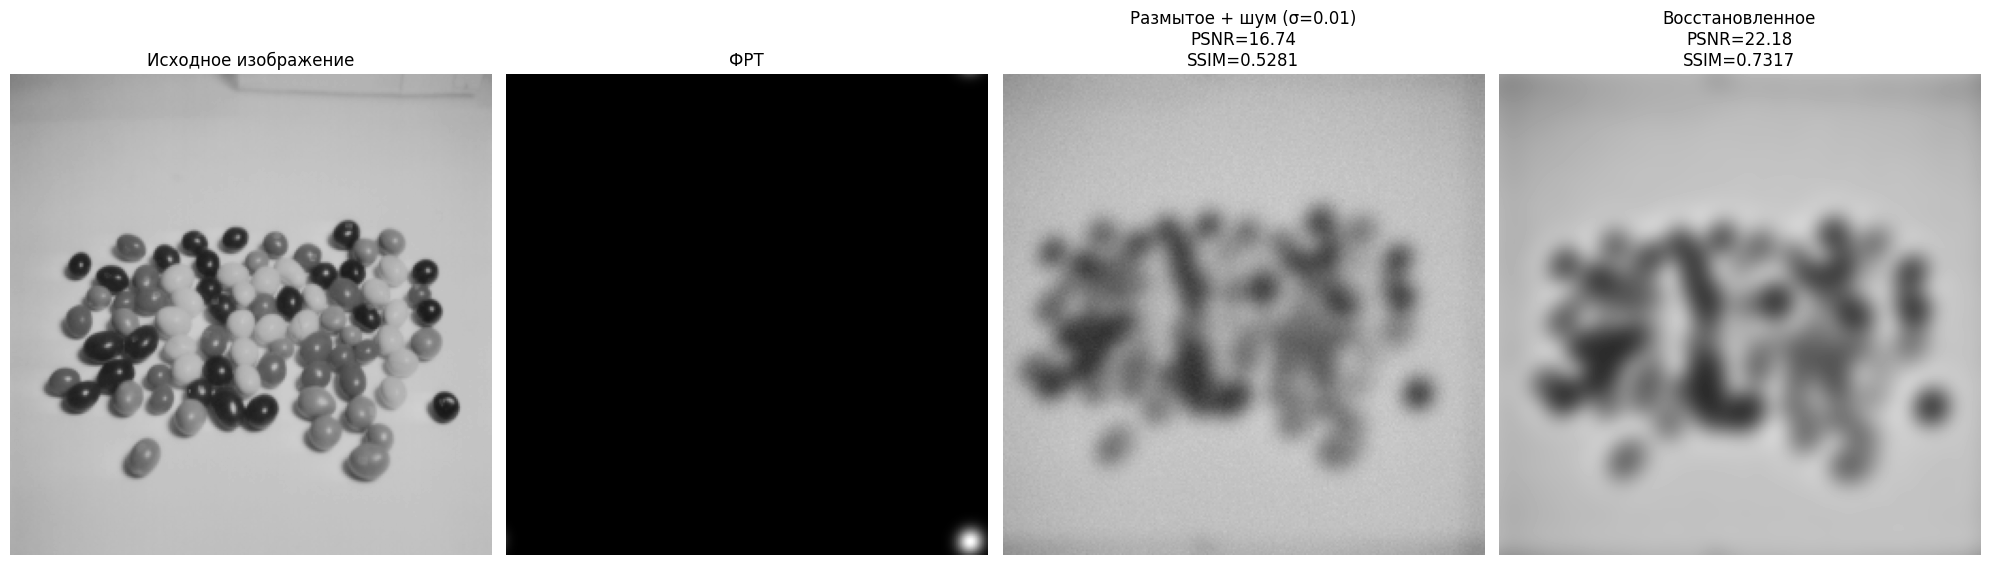


Обработка 4.1.08_frt1_noise0.1.pt
Выполнение Ричардсона-Люси:
Алгоритм остановлен на итерации 3 из-за достижения заданной точности.


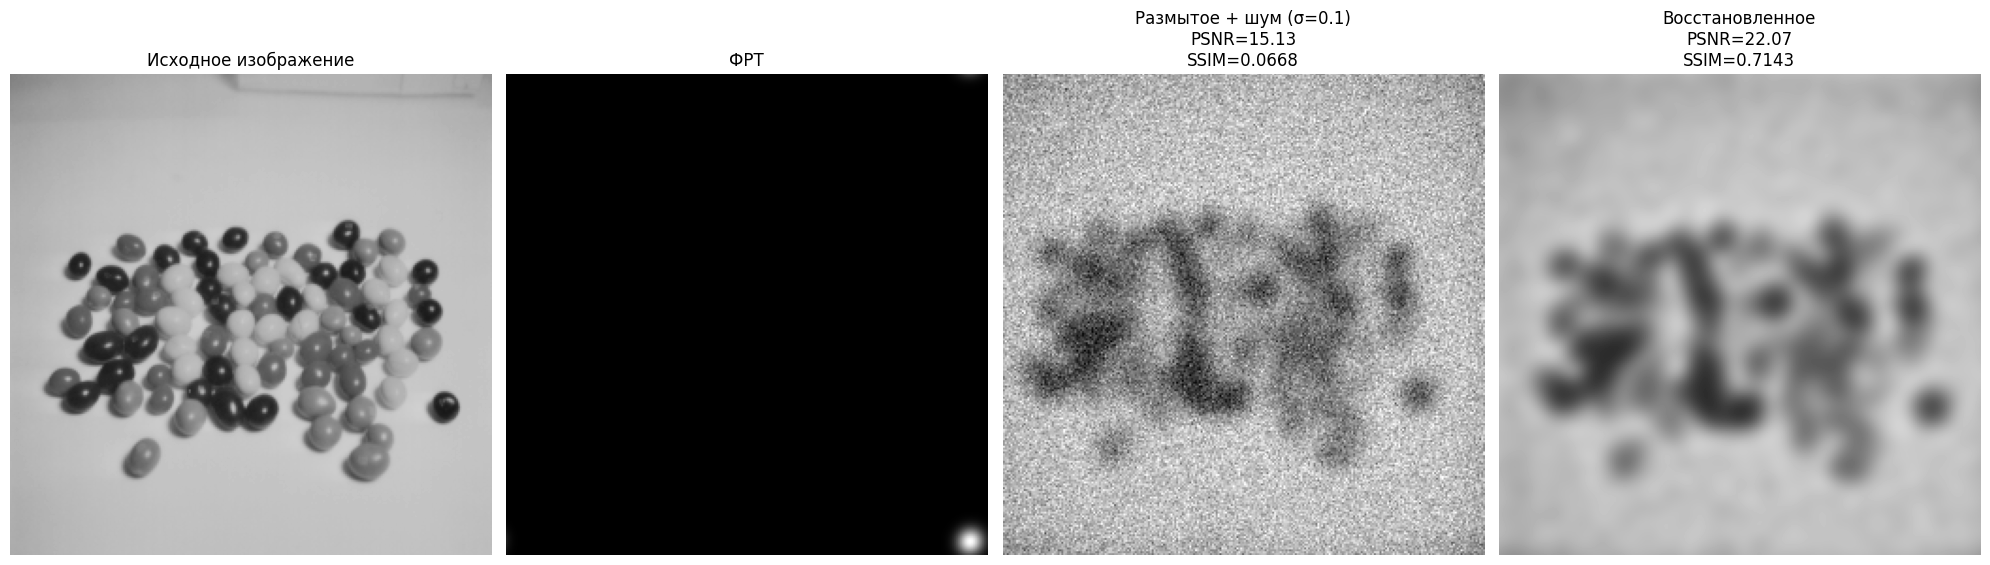


Обработка 4.1.08_frt1_noise0.05.pt
Выполнение Ричардсона-Люси:
Алгоритм остановлен на итерации 3 из-за достижения заданной точности.


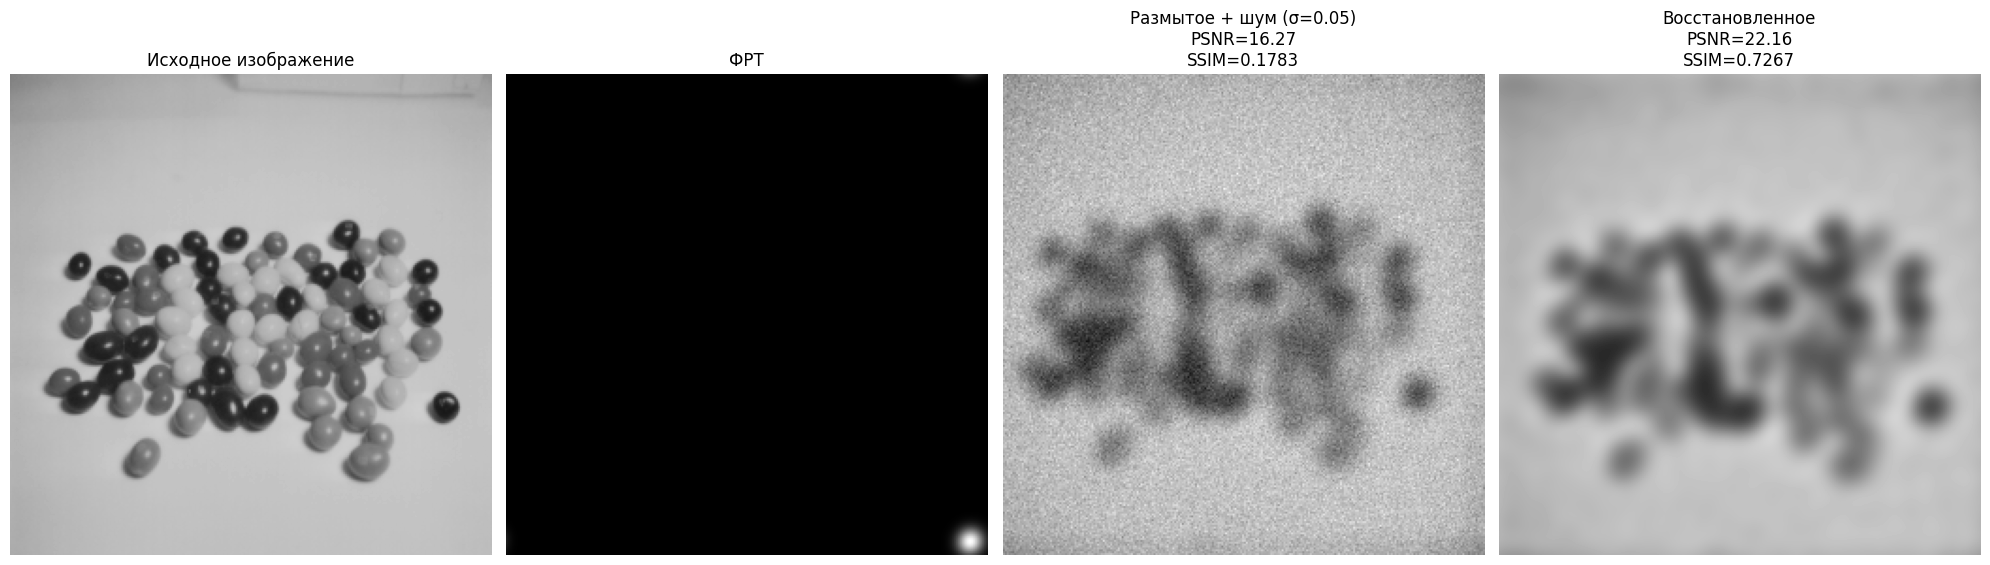


Обработка завершена!
Результаты сохранены в директории: результаты_восстановления_rich_1set_frt1_m
Метрики сохранены в файле: результаты_восстановления_rich_1set_frt1_m/metrics.txt


In [28]:

output_dir = "выходные_данные_1_frt1"
results_dir = "результаты_восстановления_rich_1set_frt1_m"
work_with_image(results_dir, output_dir, richardson_lucy, 'rich')

